### Notebook to demonstarete the effect of regularization on model performance

In [2]:
!pip install mxnet-cu101mkl

     |████████████████████████████████| 587.7MB 29kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


### Synthetic data generator

In [0]:
def synthetic_data(n_train, w, b):

  X = mx.nd.normal(0, 0.1, (n_train, w.shape[0]))
  y = mx.nd.dot(X, w) + b
  y = y + mx.nd.normal(0, 0.1, (y.shape))
  
  return X,y

In [0]:
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import nn
import mxnet as mx

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = mx.nd.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(n_train, true_w, true_b)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(n_test, true_w, true_b)
test_iter = load_array(test_data, batch_size)

# Parameter initialization

In [0]:
def init_params():
    w = mx.nd.random.normal(0, 0.1, (num_inputs, 1))
    b = mx.nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### L-2 term

divided by 2 to make differentiation easy

In [0]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Linear Regression

In [0]:
def linreg( parameters, X):

  """
  Linear regression equation


  X : m x n matrix

  w : n x n matrix

  b : bias term
  """

  y = mx.nd.dot(X, parameters[0]) + parameters[1] 

  return y

### Squared loss

In [0]:
def squared_loss(y_hat, y):

  """

  y_hat : estimate of y

  y : actual value of y

  returns: squared loss 
  """

  return (y_hat - y.reshape(y_hat.shape))**2 / 2

### Animator class to plot training progress

In [0]:
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

class Animator:

  def __init__(self , x, y, title, labels, range, figsize, xlabel, ylabel ):

    self.x = x
    self.y = y
    self.title = title
    self.labels = labels
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.range = range
    self.figsize = figsize



  def add_to_plot(self, x, y):

    """
    x : list of data points you want to add to x axis dimension : n
    y: list of lists where each list has a dimension n (n is the number of individual line plots)
    """
    # print("Hi")
    self.x = self.x + x
    for i, yi in enumerate(self.y):
      yi[:] = yi + y[i]
    

  

    sns.set_style("darkgrid")

    for i,j in enumerate(self.y):
      print(j)
      plt.legend().remove()
      plt.plot(self.x,j, label = self.labels[i])
    plt.legend()
    plt.title(self.title)
    plt.xlabel(self.xlabel)
    plt.ylabel(self.ylabel)

    
    display.clear_output(wait=True)
    plt.show()


    display.display(plt)
    

In [0]:
class Accumulator():

  def __init__(self, size):

    self.n = size

    self.data = [0] * self.n

  def add(self, *args):

    self.data = [x + y for x,y in zip(self.data, args)]

  def reset(self):
    self.data = [0] * self.n

  def __getitem__(self, i):

    if type(self.data[i]) == int:
      return self.data[i]

    return self.data[i].astype(float)[0]

Stochastic gradient descent as updater

In [0]:
def sgd(params, lr, batch_size):
  for param in params:
    param[:] = param - lr * param.grad / batch_size

In [0]:
def evaluate_loss(net, data_iter1, loss):

  metric1  = Accumulator(2)

  for X,y in data_iter1:

    metric1.add(loss(net(X), y).sum(), y.size)
  # print(metric1[0]/metric1[1])
  return metric1[0]/metric1[1]


In [0]:
def train(lamba):
  w = init_params()[0]
  b = init_params()[1]
  net, loss = lambda X: linreg([w, b], X), squared_loss
  num_epochs, lr = 100, 0.003
  train_iter = load_array(train_data, batch_size)
  test_iter = load_array(test_data, batch_size )
  train_iter = list(train_iter)
  test_iter = list(test_iter)

  animator = Animator([],[[],[]], "Performance metrics", ["train loss", "test loss"], (3,4), (3,4), "epoch", "value")


  for epoch in range(1, num_epochs + 1):
      for X, y in train_iter:
          with autograd.record():
              # The L2 norm penalty term has been added
              l = loss(net(X), y) + lamba * l2_penalty(w)
          l.backward()
          sgd([w, b], lr, batch_size)
      if epoch % 5 == 0:
          animator.add_to_plot([epoch+1], ([[evaluate_loss(net, train_iter, loss).asnumpy()[0]],
                                  [evaluate_loss(net, test_iter, loss).asnumpy()[0]]]))
  print('l1 norm of w:', mx.nd.abs(w).sum())


### No Regularization

lambda = 0

We can see that test performance cannot be improved

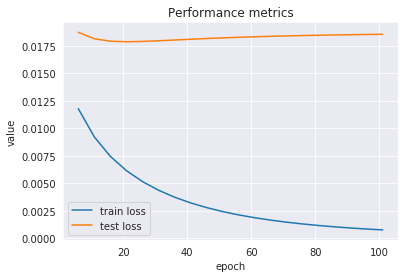

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

l1 norm of w: 
[16.114279]
<NDArray 1 @cpu(0)>


In [76]:
train(lamba = 0)

### With Regularization:

Though train loss increases, the test loss came down as compared to no regularization

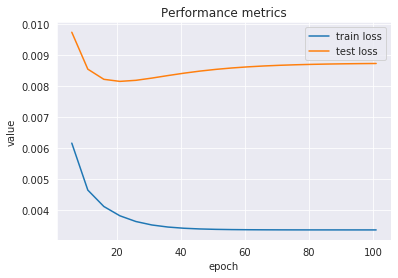

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

l1 norm of w: 
[0.1268076]
<NDArray 1 @cpu(0)>


In [78]:
train(lamba=3)


### Concise Implementation of weight decay demonstration using gluon

In [0]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    train_iter = load_array(train_data, batch_size)
    test_iter = load_array(test_data, batch_size )
    train_iter = list(train_iter)
    test_iter = list(test_iter)
    num_epochs, lr = 100, 0.003
    # The weight parameter has been decayed. Weight names generally end with
    # "weight"
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    animator = Animator([],[[],[]], "Performance metrics", ["train loss", "test loss"], (3,4), (3,4), "epoch", "value")

    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # Call the step function on each of the two Trainer instances to
            # update the weight and bias separately
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        if epoch % 5 == 0:
            animator.add_to_plot([epoch+1], ([[evaluate_loss(net, train_iter, loss).asnumpy()[0]],
                                   [evaluate_loss(net, test_iter, loss).asnumpy()[0]]]))
    print('L1 norm of w:', mx.nd.abs(net[0].weight.data()).sum())

Same trend without regularization. test performance cannot be improved

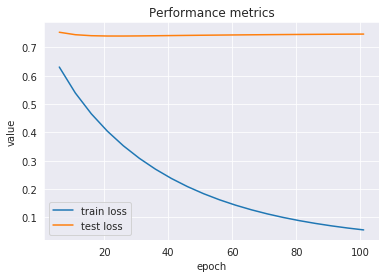

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

L1 norm of w: 
[142.7935]
<NDArray 1 @cpu(0)>


In [93]:
train_gluon(0)


### With weight decay the test performance can be improved to great extent and also closer to train performance

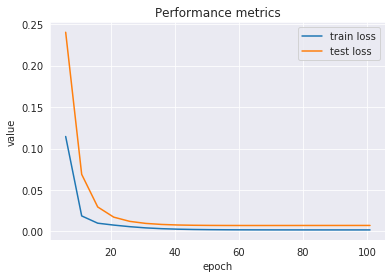

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

L1 norm of w: 
[0.09557247]
<NDArray 1 @cpu(0)>


In [94]:
train_gluon(3)